In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
dir = r'C:\Users\ruths\Desktop\self driving car'
columns = ["center", "left", "right", "steering", "throttle", "reverse", "speed"]
data = pd.read_csv(os.path.join(dir, "driving_log.csv"), names=columns)
pd.set_option("display.max_colwidth", -1)
data.head()

center  \
0  D:\IMG\center_2022_06_08_23_50_23_835.jpg   
1  D:\IMG\center_2022_06_08_23_50_23_910.jpg   
2  D:\IMG\center_2022_06_08_23_50_23_982.jpg   
3  D:\IMG\center_2022_06_08_23_50_24_055.jpg   
4  D:\IMG\center_2022_06_08_23_50_24_129.jpg   

                                      left  \
0  D:\IMG\left_2022_06_08_23_50_23_835.jpg   
1  D:\IMG\left_2022_06_08_23_50_23_910.jpg   
2  D:\IMG\left_2022_06_08_23_50_23_982.jpg   
3  D:\IMG\left_2022_06_08_23_50_24_055.jpg   
4  D:\IMG\left_2022_06_08_23_50_24_129.jpg   

                                      right  steering  throttle  reverse  \
0  D:\IMG\right_2022_06_08_23_50_23_835.jpg  0.0       0.0       0.0       
1  D:\IMG\right_2022_06_08_23_50_23_910.jpg  0.0       0.0       0.0       
2  D:\IMG\right_2022_06_08_23_50_23_982.jpg  0.0       0.0       0.0       
3  D:\IMG\right_2022_06_08_23_50_24_055.jpg  0.0       0.0       0.0       
4  D:\IMG\right_2022_06_08_23_50_24_129.jpg  0.0       0.0       0.0       

          speed  
0  5.196667e-07  
1  1.074897e-05  
2  4.298026e-06  
3  1.716151e-06  
4  1.811432e-06

In [3]:
def pathleaf(path):
    head, tail = ntpath.split(path)
    return tail

data["center"] = data["center"].apply(pathleaf)
data["left"] = data["left"].apply(pathleaf)
data["right"] = data["right"].apply(pathleaf)
data.head()

center                              left  \
0  center_2022_06_08_23_50_23_835.jpg  left_2022_06_08_23_50_23_835.jpg   
1  center_2022_06_08_23_50_23_910.jpg  left_2022_06_08_23_50_23_910.jpg   
2  center_2022_06_08_23_50_23_982.jpg  left_2022_06_08_23_50_23_982.jpg   
3  center_2022_06_08_23_50_24_055.jpg  left_2022_06_08_23_50_24_055.jpg   
4  center_2022_06_08_23_50_24_129.jpg  left_2022_06_08_23_50_24_129.jpg   

                               right  steering  throttle  reverse  \
0  right_2022_06_08_23_50_23_835.jpg  0.0       0.0       0.0       
1  right_2022_06_08_23_50_23_910.jpg  0.0       0.0       0.0       
2  right_2022_06_08_23_50_23_982.jpg  0.0       0.0       0.0       
3  right_2022_06_08_23_50_24_055.jpg  0.0       0.0       0.0       
4  right_2022_06_08_23_50_24_129.jpg  0.0       0.0       0.0       

          speed  
0  5.196667e-07  
1  1.074897e-05  
2  4.298026e-06  
3  1.716151e-06  
4  1.811432e-06

In [4]:
num_bins = 25
samples_per_bin = 300
hist, bins = np.histogram(data["steering"], num_bins)
print(bins)

[-0.9000002  -0.83000019 -0.76000018 -0.69000016 -0.62000015 -0.55000014
 -0.48000013 -0.41000012 -0.3400001  -0.27000009 -0.20000008 -0.13000007
 -0.06000006  0.00999996  0.07999997  0.14999998  0.21999999  0.29
  0.36000002  0.43000003  0.50000004  0.57000005  0.64000006  0.71000008
  0.78000009  0.8500001 ]


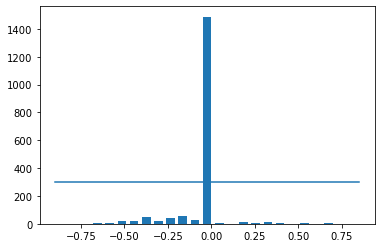

In [5]:
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot(
    (np.min(data["steering"]), np.max(data["steering"])),
    (samples_per_bin, samples_per_bin),
)

In [6]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data["steering"])):
        if data["steering"][i] >= bins[j] and data["steering"][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
print("Removed:", len(remove_list))

Removed: 1188


In [7]:
data.drop(data.index[remove_list], inplace=True)
print("Remaining:", len(data))


Remaining: 598


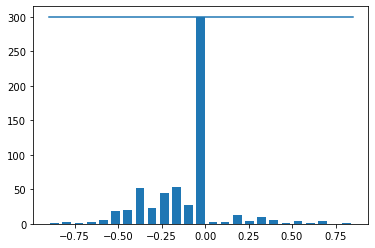

In [8]:
hist, _ = np.histogram(data["steering"], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot(
    (np.min(data["steering"]), np.max(data["steering"])),
    (samples_per_bin, samples_per_bin),
)

In [9]:
print(data.iloc[1])

center      center_2022_06_08_23_50_24_351.jpg
left        left_2022_06_08_23_50_24_351.jpg  
right       right_2022_06_08_23_50_24_351.jpg 
steering    0.0                               
throttle    0.0                               
reverse     0.0                               
speed       0.000001                          
Name: 7, dtype: object


In [10]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        image_path.append(os.path.join(datadir, left.strip()))
        steering.append(float(indexed_data[3]) + 0.15)
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3]) - 0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

In [11]:
image_paths, steerings = load_img_steering(dir + "/IMG", data)
X_train, X_valid, y_train, y_valid = train_test_split(
    image_paths, steerings, test_size=0.2, random_state=6
)
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))

Training Samples: 1435
Valid Samples: 359


Text(0.5, 1.0, 'Validation set')

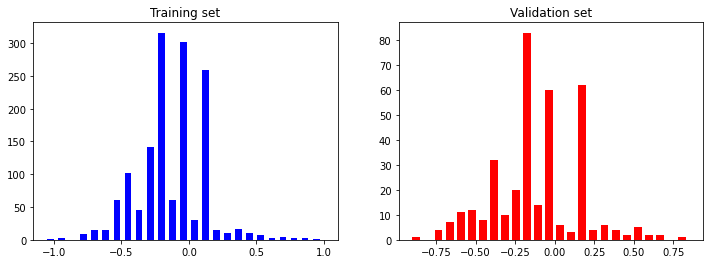

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'Zoomed Image')

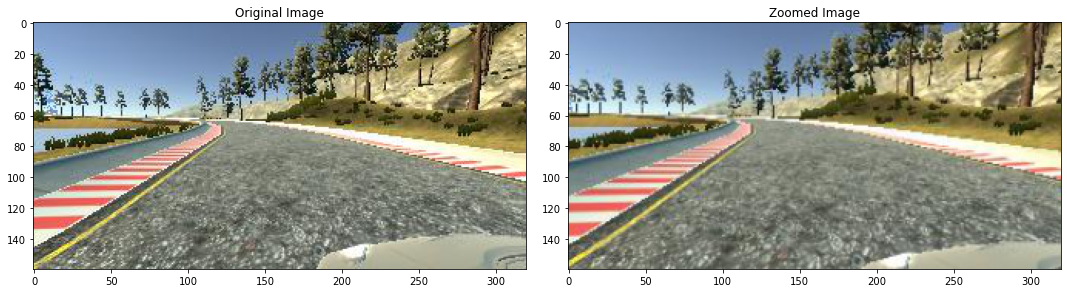

In [13]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(zoomed_image)
axs[1].set_title("Zoomed Image")

Text(0.5, 1.0, 'Flipped Image - Steering Angle:-0.15')

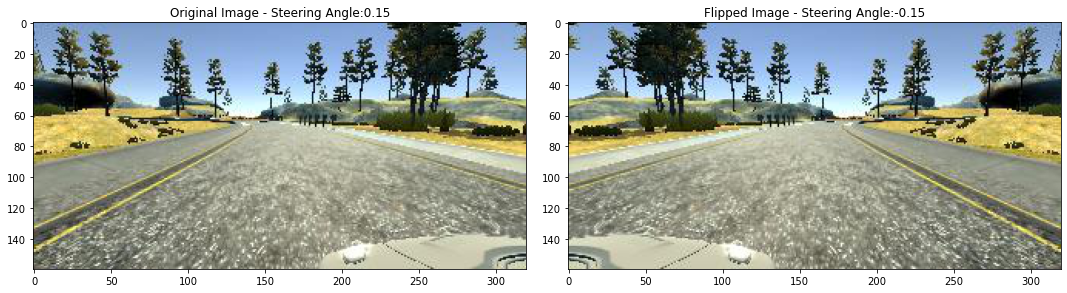

In [14]:
def random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image - " + "Steering Angle:" + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title("Flipped Image - " + "Steering Angle:" + str(flipped_steering_angle))

Text(0.5, 1.0, 'Panned Image')

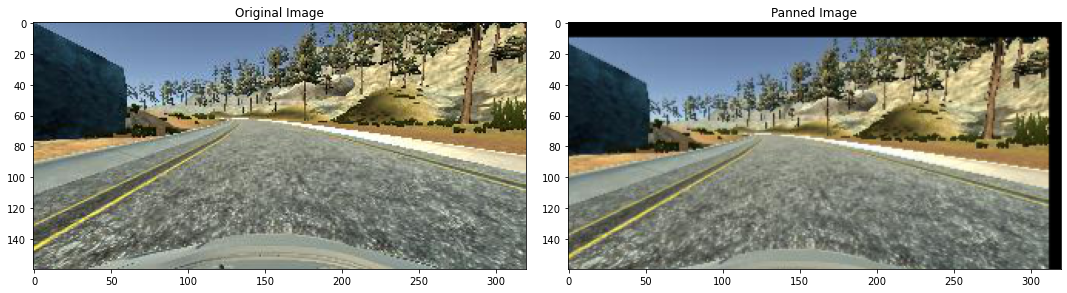

In [15]:
def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(panned_image)
axs[1].set_title("Panned Image")

Text(0.5, 1.0, 'Brightness altered image ')

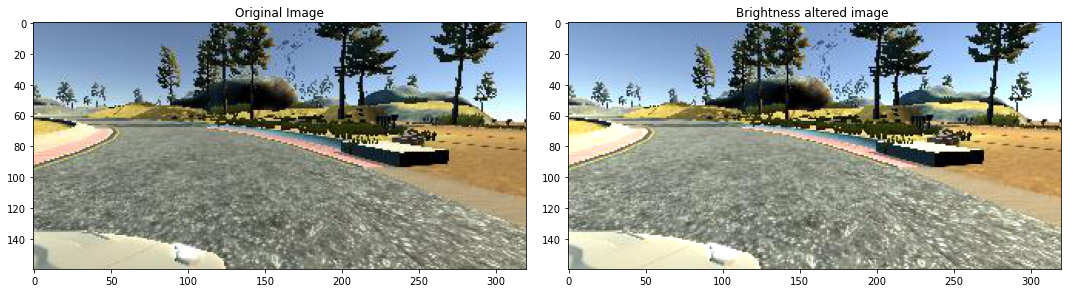

In [16]:
def random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(brightness_altered_image)
axs[1].set_title("Brightness altered image ")

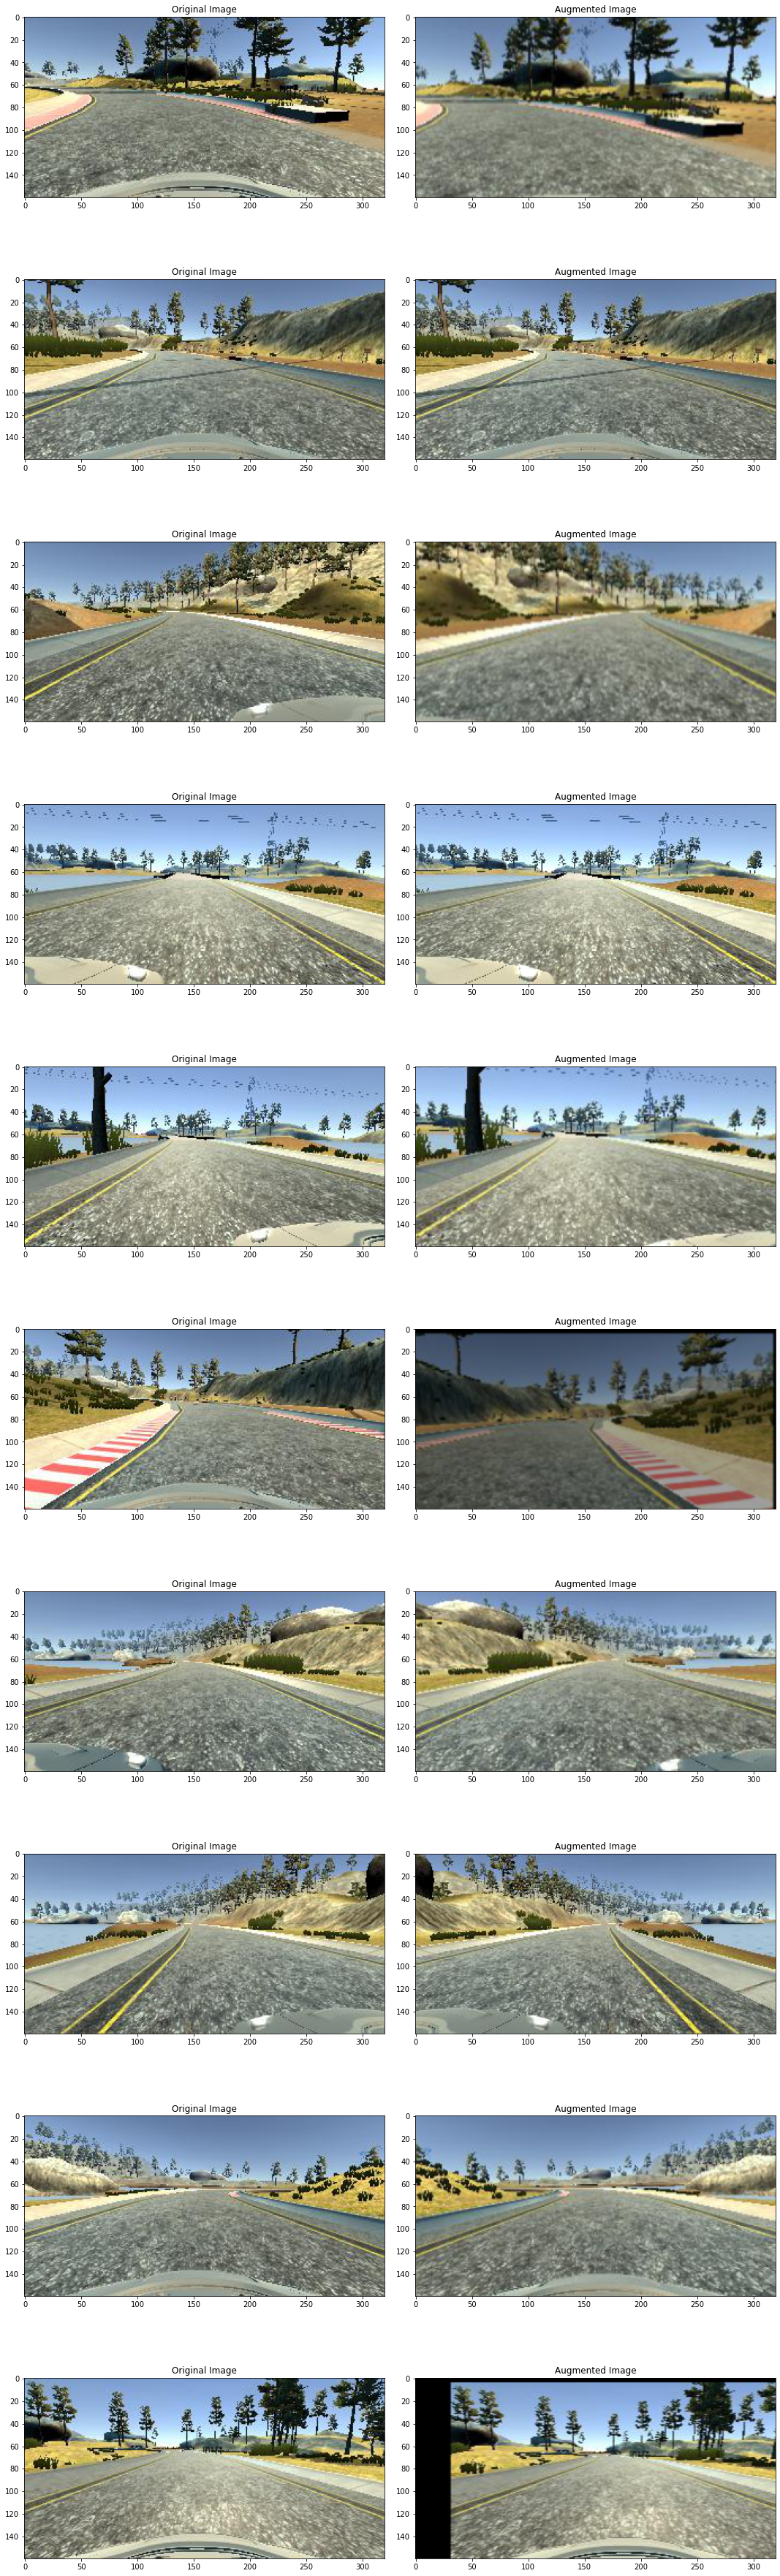

In [17]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = random_flip(image, steering_angle)
    return image, steering_angle

ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

In [19]:
def img_preprocess(img):
    ## Crop image to remove unnecessary features
    img = img[60:135, :, :]
    ## Change to YUV image
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    ## Gaussian blur
    img = cv2.GaussianBlur(img, (3, 3), 0)
    ## Decrease size for easier processing
    img = cv2.resize(img, (200, 66))
    ## Normalize values
    img = img / 255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

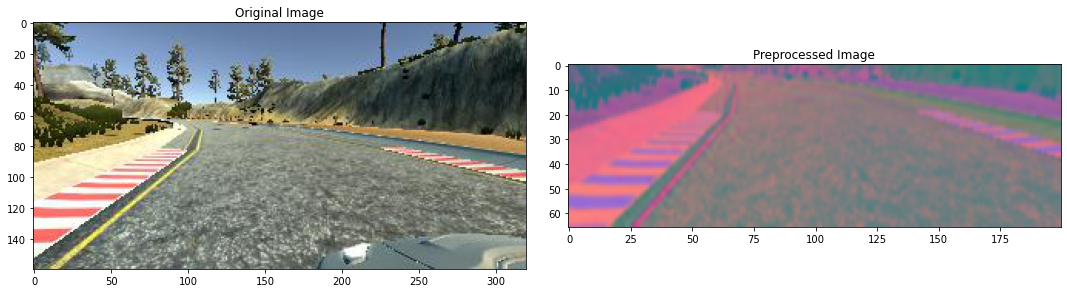

In [20]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(preprocessed_image)
axs[1].set_title("Preprocessed Image")

In [21]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
                im, steering = random_augment(
                    image_paths[random_index], steering_ang[random_index]
                )

            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)

        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

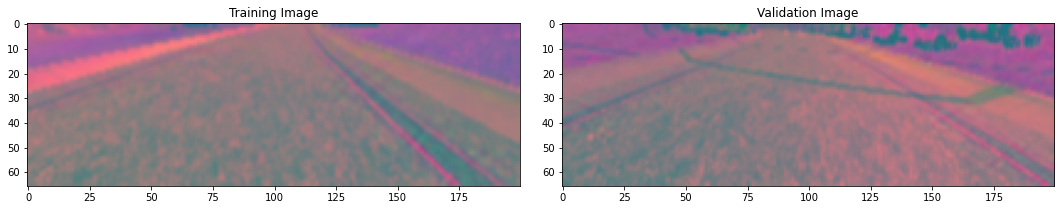

In [22]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title("Training Image")

axs[1].imshow(x_valid_gen[0])
axs[1].set_title("Validation Image")

In [23]:
def NvidiaModel():
    model = Sequential()
    model.add(Convolution2D(24,(5,5),strides=(2,2),input_shape=(66,200,3),activation="elu"))
    model.add(Convolution2D(36,(5,5),strides=(2,2),activation="elu"))
    model.add(Convolution2D(48,(5,5),strides=(2,2),activation="elu")) 
    model.add(Convolution2D(64,(3,3),activation="elu"))   
    model.add(Convolution2D(64,(3,3),activation="elu"))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100,activation="elu"))
    model.add(Dropout(0.5))
    model.add(Dense(50,activation="elu"))
    model.add(Dropout(0.5))
    model.add(Dense(10,activation="elu"))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=1e-3),loss="mse")
    return model

In [24]:
model = NvidiaModel()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 1, 18, 64)         0         
                                                                 
 flatten (Flatten)           (None, 1152)              0

In [25]:
history = model.fit_generator(
    batch_generator(X_train, y_train, 100, 1),
    steps_per_epoch=300,
    epochs=10,
    validation_data=batch_generator(X_valid, y_valid, 100, 0),
    validation_steps=200,
    verbose=1,
    shuffle=1,
)

Epoch 1/10
300/300 [==============================] - 454s 2s/step - loss: 0.1090 - val_loss: 0.0712
Epoch 2/10
300/300 [==============================] - 439s 1s/step - loss: 0.0684 - val_loss: 0.0618
Epoch 3/10
300/300 [==============================] - 404s 1s/step - loss: 0.0657 - val_loss: 0.0595
Epoch 4/10
300/300 [==============================] - 412s 1s/step - loss: 0.0639 - val_loss: 0.0611
Epoch 5/10
300/300 [==============================] - 399s 1s/step - loss: 0.0616 - val_loss: 0.0620
Epoch 6/10
300/300 [==============================] - 402s 1s/step - loss: 0.0590 - val_loss: 0.0539
Epoch 7/10
300/300 [==============================] - 398s 1s/step - loss: 0.0601 - val_loss: 0.0586
Epoch 8/10
300/300 [==============================] - 403s 1s/step - loss: 0.0585 - val_loss: 0.0532
Epoch 9/10
300/300 [==============================] - 407s 1s/step - loss: 0.0579 - val_loss: 0.0529
Epoch 10/10
300/300 [==============================] - 404s 1s/step - loss: 0.0587 - val_lo

Text(0.5, 0, 'Epoch')

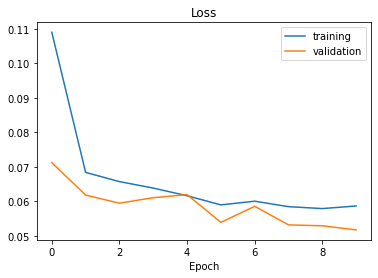

In [26]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["training", "validation"])
plt.title("Loss")
plt.xlabel("Epoch")

In [27]:
model.save('model.h5')